In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import zipfile

ZIP_PATH = "/content/drive/MyDrive/brisc2025.zip"
EXTRACT_ROOT = "/content/datasets"


In [3]:
os.makedirs(EXTRACT_ROOT, exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_ROOT)

print("✅ ZIP extracted successfully")


✅ ZIP extracted successfully


In [4]:
# Find the BRISC root directory dynamically
def find_brisc_root(base_dir):
    for root, dirs, files in os.walk(base_dir):
        if "classification_task" in dirs and "segmentation_task" in dirs:
            return root
    return None

BRISC_ROOT = find_brisc_root(EXTRACT_ROOT)

if BRISC_ROOT is None:
    raise RuntimeError("❌ BRISC dataset root not found")

print(f"✅ BRISC root detected at: {BRISC_ROOT}")


✅ BRISC root detected at: /content/datasets/brisc2025


In [5]:
CLASSIFICATION_DIR = os.path.join(BRISC_ROOT, "classification_task")
SEGMENTATION_DIR = os.path.join(BRISC_ROOT, "segmentation_task")

SEG_IMAGES_DIR = os.path.join(SEGMENTATION_DIR, "images")
SEG_MASKS_DIR  = os.path.join(SEGMENTATION_DIR, "masks")


In [6]:
import os

print("📁 BRISC ROOT:")
print(os.listdir(BRISC_ROOT))

print("\n📁 segmentation_task contents:")
print(os.listdir(SEGMENTATION_DIR))


📁 BRISC ROOT:
['manifest.json.sha256', 'README.md', 'classification_task', 'manifest.json', 'segmentation_task', 'manifest.csv', 'manifest.csv.sha256']

📁 segmentation_task contents:
['train', 'test']


In [7]:
import os

print("📁 segmentation_task/train:")
print(os.listdir(os.path.join(SEGMENTATION_DIR, "train")))

print("\n📁 segmentation_task/test:")
print(os.listdir(os.path.join(SEGMENTATION_DIR, "test")))


📁 segmentation_task/train:
['masks', 'images']

📁 segmentation_task/test:
['masks', 'images']


In [8]:
SEG_TRAIN_DIR = os.path.join(SEGMENTATION_DIR, "train")
SEG_TEST_DIR  = os.path.join(SEGMENTATION_DIR, "test")

TRAIN_IMAGES_DIR = os.path.join(SEG_TRAIN_DIR, "images")
TRAIN_MASKS_DIR  = os.path.join(SEG_TRAIN_DIR, "masks")

TEST_IMAGES_DIR  = os.path.join(SEG_TEST_DIR, "images")
TEST_MASKS_DIR   = os.path.join(SEG_TEST_DIR, "masks")


In [9]:
assert os.path.isdir(TRAIN_IMAGES_DIR), "❌ train/images missing"
assert os.path.isdir(TRAIN_MASKS_DIR),  "❌ train/masks missing"
assert os.path.isdir(TEST_IMAGES_DIR),  "❌ test/images missing"
assert os.path.isdir(TEST_MASKS_DIR),   "❌ test/masks missing"

print("✅ BRISC train/test image & mask folders verified")


✅ BRISC train/test image & mask folders verified


In [10]:
print("Train images:", len(os.listdir(TRAIN_IMAGES_DIR)))
print("Train masks :", len(os.listdir(TRAIN_MASKS_DIR)))
print("Test images :", len(os.listdir(TEST_IMAGES_DIR)))
print("Test masks  :", len(os.listdir(TEST_MASKS_DIR)))


Train images: 3933
Train masks : 3933
Test images : 860
Test masks  : 860


In [11]:
!pip install opencv-python albumentations


In [12]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

IMAGE_SIZE = 256

train_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),   # light augmentation
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.5, 0.5, 0.5),
                std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(mean=(0.5, 0.5, 0.5),
                std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])


In [13]:
import cv2
import torch
from torch.utils.data import Dataset
import os

class BRISCSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform

        self.images = sorted(os.listdir(images_dir))
        self.masks  = sorted(os.listdir(masks_dir))

        assert len(self.images) == len(self.masks), "Image–mask mismatch"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path  = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype("float32")

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask  = augmented["mask"].unsqueeze(0)

        return image, mask


In [14]:
train_dataset = BRISCSegmentationDataset(
    TRAIN_IMAGES_DIR,
    TRAIN_MASKS_DIR,
    transform=train_transform
)

test_dataset = BRISCSegmentationDataset(
    TEST_IMAGES_DIR,
    TEST_MASKS_DIR,
    transform=test_transform
)

print("Train:", len(train_dataset))
print("Test :", len(test_dataset))


Train: 3933
Test : 860


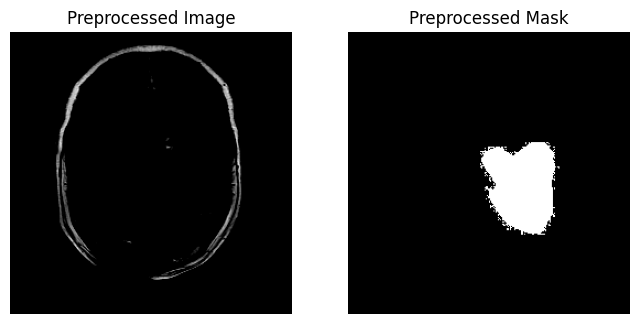

In [15]:
import matplotlib.pyplot as plt

img, mask = train_dataset[0]

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img.permute(1,2,0))
plt.title("Preprocessed Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask.squeeze(), cmap="gray")
plt.title("Preprocessed Mask")
plt.axis("off")

plt.show()


In [16]:
!pip install segmentation-models-pytorch torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 46.3 MB/s eta 0:00:00


In [17]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
import segmentation_models_pytorch as smp


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [19]:
BATCH_SIZE = 8
NUM_WORKERS = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)


In [20]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [21]:
loss_fn = smp.losses.DiceLoss(mode="binary")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [22]:
def dice_score(preds, targets, smooth=1e-6):
    preds = preds.contiguous()
    targets = targets.contiguous()

    intersection = (preds * targets).sum(dim=(2,3))
    union = preds.sum(dim=(2,3)) + targets.sum(dim=(2,3))

    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()


def iou_score(preds, targets, smooth=1e-6):
    intersection = (preds * targets).sum(dim=(2,3))
    total = preds.sum(dim=(2,3)) + targets.sum(dim=(2,3))
    union = total - intersection

    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()


In [23]:
def train_one_epoch(model, loader, optimizer, loss_fn):
    model.train()
    epoch_loss = 0.0

    for images, masks in tqdm(loader):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader)


In [24]:
def evaluate(model, loader):
    model.eval()
    dice_scores = []
    iou_scores = []

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            d = dice_score(preds, masks)
            i = iou_score(preds, masks)

            dice_scores.append(d.item())
            iou_scores.append(i.item())

    return np.mean(dice_scores), np.mean(iou_scores)


In [25]:
EPOCHS = 25
best_dice = 0.0

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn)
    val_dice, val_iou = evaluate(model, test_loader)

    print(f"Epoch [{epoch+1}/{EPOCHS}] | "
          f"Train Loss: {train_loss:.4f} | "
          f"Dice: {val_dice:.4f} | "
          f"IoU: {val_iou:.4f}")

    if val_dice > best_dice:
        best_dice = val_dice
        torch.save(model.state_dict(), "unet_baseline_brisc.pth")
        print("✅ Best U-Net model saved")


100%|██████████| 492/492 [01:01<00:00,  8.00it/s]


Epoch [1/25] | Train Loss: 0.6664 | Dice: 0.7601 | IoU: 0.6563
✅ Best U-Net model saved


100%|██████████| 492/492 [01:00<00:00,  8.08it/s]


Epoch [2/25] | Train Loss: 0.2788 | Dice: 0.7703 | IoU: 0.6692
✅ Best U-Net model saved


100%|██████████| 492/492 [01:01<00:00,  7.98it/s]


Epoch [3/25] | Train Loss: 0.2141 | Dice: 0.7543 | IoU: 0.6551


100%|██████████| 492/492 [01:01<00:00,  7.99it/s]


Epoch [4/25] | Train Loss: 0.1948 | Dice: 0.7905 | IoU: 0.6949
✅ Best U-Net model saved


100%|██████████| 492/492 [01:01<00:00,  7.99it/s]


Epoch [5/25] | Train Loss: 0.1797 | Dice: 0.8006 | IoU: 0.7056
✅ Best U-Net model saved


100%|██████████| 492/492 [01:01<00:00,  8.00it/s]


Epoch [6/25] | Train Loss: 0.1677 | Dice: 0.8058 | IoU: 0.7108
✅ Best U-Net model saved


100%|██████████| 492/492 [01:01<00:00,  8.00it/s]


Epoch [7/25] | Train Loss: 0.1618 | Dice: 0.7901 | IoU: 0.6983


100%|██████████| 492/492 [01:01<00:00,  8.02it/s]


Epoch [8/25] | Train Loss: 0.1627 | Dice: 0.8039 | IoU: 0.7076


100%|██████████| 492/492 [01:01<00:00,  8.01it/s]


Epoch [9/25] | Train Loss: 0.1563 | Dice: 0.8144 | IoU: 0.7189
✅ Best U-Net model saved


100%|██████████| 492/492 [01:01<00:00,  8.00it/s]


Epoch [10/25] | Train Loss: 0.1540 | Dice: 0.7522 | IoU: 0.6581


100%|██████████| 492/492 [01:01<00:00,  7.99it/s]


Epoch [11/25] | Train Loss: 0.1642 | Dice: 0.8215 | IoU: 0.7262
✅ Best U-Net model saved


100%|██████████| 492/492 [01:01<00:00,  8.02it/s]


Epoch [12/25] | Train Loss: 0.1590 | Dice: 0.8167 | IoU: 0.7205


100%|██████████| 492/492 [01:01<00:00,  8.00it/s]


Epoch [13/25] | Train Loss: 0.1481 | Dice: 0.8106 | IoU: 0.7168


100%|██████████| 492/492 [01:01<00:00,  7.99it/s]


Epoch [14/25] | Train Loss: 0.1534 | Dice: 0.8014 | IoU: 0.7096


100%|██████████| 492/492 [01:01<00:00,  8.00it/s]


Epoch [15/25] | Train Loss: 0.1487 | Dice: 0.8198 | IoU: 0.7267


100%|██████████| 492/492 [01:01<00:00,  8.00it/s]


Epoch [16/25] | Train Loss: 0.1437 | Dice: 0.8183 | IoU: 0.7271


100%|██████████| 492/492 [01:01<00:00,  8.01it/s]


Epoch [17/25] | Train Loss: 0.1421 | Dice: 0.8306 | IoU: 0.7359
✅ Best U-Net model saved


100%|██████████| 492/492 [01:01<00:00,  7.99it/s]


Epoch [18/25] | Train Loss: 0.1459 | Dice: 0.8220 | IoU: 0.7296


100%|██████████| 492/492 [01:01<00:00,  8.00it/s]


Epoch [19/25] | Train Loss: 0.1417 | Dice: 0.8115 | IoU: 0.7196


100%|██████████| 492/492 [01:01<00:00,  7.99it/s]


Epoch [20/25] | Train Loss: 0.1493 | Dice: 0.8087 | IoU: 0.7189


100%|██████████| 492/492 [01:01<00:00,  8.00it/s]


Epoch [21/25] | Train Loss: 0.1424 | Dice: 0.8278 | IoU: 0.7364


100%|██████████| 492/492 [01:01<00:00,  7.99it/s]


Epoch [22/25] | Train Loss: 0.1359 | Dice: 0.8262 | IoU: 0.7324


100%|██████████| 492/492 [01:01<00:00,  7.98it/s]


Epoch [23/25] | Train Loss: 0.1381 | Dice: 0.8311 | IoU: 0.7382
✅ Best U-Net model saved


100%|██████████| 492/492 [01:01<00:00,  7.98it/s]


Epoch [24/25] | Train Loss: 0.1389 | Dice: 0.8249 | IoU: 0.7321


100%|██████████| 492/492 [01:01<00:00,  7.98it/s]


Epoch [25/25] | Train Loss: 0.1363 | Dice: 0.8195 | IoU: 0.7264


In [26]:
def pixel_accuracy(preds, targets):
    correct = (preds == targets).float().sum()
    total = torch.numel(preds)
    return correct / total


In [27]:
def evaluate(model, loader):
    model.eval()
    dice_scores = []
    iou_scores = []
    acc_scores = []

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            d = dice_score(preds, masks)
            i = iou_score(preds, masks)
            a = pixel_accuracy(preds, masks)

            dice_scores.append(d.item())
            iou_scores.append(i.item())
            acc_scores.append(a.item())

    return (
        np.mean(dice_scores),
        np.mean(iou_scores),
        np.mean(acc_scores)
    )


In [28]:
val_dice, val_iou, val_acc = evaluate(model, test_loader)

print(f"Epoch [{epoch+1}/{EPOCHS}] | "
      f"Train Loss: {train_loss:.4f} | "
      f"Dice: {val_dice:.4f} | "
      f"IoU: {val_iou:.4f} | "
      f"Accuracy: {val_acc:.4f}")


Epoch [25/25] | Train Loss: 0.1363 | Dice: 0.8195 | IoU: 0.7264 | Accuracy: 0.9943


In [29]:
!pip install -q timm


In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [32]:
class ConvNeXtEncoder(nn.Module):
    def __init__(self, name="convnext_tiny", pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(
            name,
            pretrained=pretrained,
            features_only=True
        )
        self.channels = self.backbone.feature_info.channels()

    def forward(self, x):
        return self.backbone(x)  # multi-scale features


In [33]:
class DecoderBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch + skip_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, skip):
        x = F.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
        x = torch.cat([x, skip], dim=1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x


In [34]:
class ConvNeXtUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = ConvNeXtEncoder("convnext_tiny", pretrained=True)

        # ConvNeXt feature channels
        ch = self.encoder.channels
        # Example: [96, 192, 384, 768]

        # Bottleneck
        self.bottleneck = nn.Conv2d(ch[-1], 512, kernel_size=3, padding=1)

        # Decoder (FULL depth)
        self.dec4 = DecoderBlock(512, ch[-2], 256)   # 8×8 → 16×16
        self.dec3 = DecoderBlock(256, ch[-3], 128)   # 16×16 → 32×32
        self.dec2 = DecoderBlock(128, ch[-4], 64)    # 32×32 → 64×64
        self.dec1 = DecoderBlock(64, 0, 32)          # 64×64 → 128×128

        # Final upsampling to 256×256
        self.final_up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 1, kernel_size=1)
        )

    def forward(self, x):
        f1, f2, f3, f4 = self.encoder(x)

        x = self.bottleneck(f4)
        x = self.dec4(x, f3)
        x = self.dec3(x, f2)
        x = self.dec2(x, f1)

        # No skip for last block
        x = F.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
        x = self.dec1.conv1(torch.cat([x], dim=1))
        x = self.dec1.relu(x)
        x = self.dec1.conv2(x)
        x = self.dec1.relu(x)

        return self.final_up(x)


In [35]:
model = ConvNeXtUNet().to(device)

def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad) / 1e6

print(f"ConvNeXt-UNet parameters: {count_params(model):.2f} M")


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

ConvNeXt-UNet parameters: 34.87 M


In [36]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-5
)


In [37]:
EPOCHS = 25
best_dice = 0.0

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(
        model,
        train_loader,
        optimizer,
        loss_fn
    )

    dice, iou, acc = evaluate(model, test_loader)

    print(f"[ConvNeXt-UNet] Epoch {epoch+1}/{EPOCHS} | "
          f"Loss: {train_loss:.4f} | "
          f"Dice: {dice:.4f} | "
          f"IoU: {iou:.4f} | "
          f"Acc: {acc:.4f}")

    if dice > best_dice:
        best_dice = dice
        torch.save(model.state_dict(), "convnext_unet_brisc.pth")
        print("✅ Best ConvNeXt-UNet saved")


100%|██████████| 492/492 [02:16<00:00,  3.60it/s]


[ConvNeXt-UNet] Epoch 1/25 | Loss: 0.0558 | Dice: 0.6459 | IoU: 0.5473 | Acc: 0.9901
✅ Best ConvNeXt-UNet saved


100%|██████████| 492/492 [02:02<00:00,  4.01it/s]


[ConvNeXt-UNet] Epoch 2/25 | Loss: 0.0223 | Dice: 0.7533 | IoU: 0.6472 | Acc: 0.9926
✅ Best ConvNeXt-UNet saved


100%|██████████| 492/492 [02:02<00:00,  4.02it/s]


[ConvNeXt-UNet] Epoch 3/25 | Loss: 0.0183 | Dice: 0.7809 | IoU: 0.6748 | Acc: 0.9928
✅ Best ConvNeXt-UNet saved


100%|██████████| 492/492 [02:02<00:00,  4.01it/s]


[ConvNeXt-UNet] Epoch 4/25 | Loss: 0.0163 | Dice: 0.7802 | IoU: 0.6768 | Acc: 0.9926


100%|██████████| 492/492 [02:02<00:00,  4.01it/s]


[ConvNeXt-UNet] Epoch 5/25 | Loss: 0.0162 | Dice: 0.7978 | IoU: 0.7003 | Acc: 0.9938
✅ Best ConvNeXt-UNet saved


100%|██████████| 492/492 [02:02<00:00,  4.02it/s]


[ConvNeXt-UNet] Epoch 6/25 | Loss: 0.0142 | Dice: 0.8168 | IoU: 0.7196 | Acc: 0.9944
✅ Best ConvNeXt-UNet saved


100%|██████████| 492/492 [02:02<00:00,  4.01it/s]


[ConvNeXt-UNet] Epoch 7/25 | Loss: 0.0135 | Dice: 0.7837 | IoU: 0.6894 | Acc: 0.9938


100%|██████████| 492/492 [02:02<00:00,  4.02it/s]


[ConvNeXt-UNet] Epoch 8/25 | Loss: 0.0138 | Dice: 0.8035 | IoU: 0.7073 | Acc: 0.9941


100%|██████████| 492/492 [02:02<00:00,  4.02it/s]


[ConvNeXt-UNet] Epoch 9/25 | Loss: 0.0127 | Dice: 0.8109 | IoU: 0.7157 | Acc: 0.9944


100%|██████████| 492/492 [02:02<00:00,  4.02it/s]


[ConvNeXt-UNet] Epoch 10/25 | Loss: 0.0121 | Dice: 0.8105 | IoU: 0.7157 | Acc: 0.9944


100%|██████████| 492/492 [02:02<00:00,  4.03it/s]


[ConvNeXt-UNet] Epoch 11/25 | Loss: 0.0129 | Dice: 0.8281 | IoU: 0.7338 | Acc: 0.9946
✅ Best ConvNeXt-UNet saved


100%|██████████| 492/492 [02:02<00:00,  4.02it/s]


[ConvNeXt-UNet] Epoch 12/25 | Loss: 0.0120 | Dice: 0.8180 | IoU: 0.7250 | Acc: 0.9945


100%|██████████| 492/492 [02:02<00:00,  4.02it/s]


[ConvNeXt-UNet] Epoch 13/25 | Loss: 0.0115 | Dice: 0.8274 | IoU: 0.7344 | Acc: 0.9945


100%|██████████| 492/492 [02:02<00:00,  4.02it/s]


[ConvNeXt-UNet] Epoch 14/25 | Loss: 0.0107 | Dice: 0.8258 | IoU: 0.7328 | Acc: 0.9948


100%|██████████| 492/492 [02:02<00:00,  4.02it/s]


[ConvNeXt-UNet] Epoch 15/25 | Loss: 0.0114 | Dice: 0.7933 | IoU: 0.7004 | Acc: 0.9941


100%|██████████| 492/492 [02:02<00:00,  4.02it/s]


[ConvNeXt-UNet] Epoch 16/25 | Loss: 0.0112 | Dice: 0.8281 | IoU: 0.7359 | Acc: 0.9947


100%|██████████| 492/492 [02:02<00:00,  4.02it/s]


[ConvNeXt-UNet] Epoch 17/25 | Loss: 0.0107 | Dice: 0.8302 | IoU: 0.7382 | Acc: 0.9948
✅ Best ConvNeXt-UNet saved


100%|██████████| 492/492 [02:02<00:00,  4.02it/s]


[ConvNeXt-UNet] Epoch 18/25 | Loss: 0.0103 | Dice: 0.8325 | IoU: 0.7381 | Acc: 0.9946
✅ Best ConvNeXt-UNet saved


100%|██████████| 492/492 [02:02<00:00,  4.02it/s]


[ConvNeXt-UNet] Epoch 19/25 | Loss: 0.0100 | Dice: 0.8128 | IoU: 0.7209 | Acc: 0.9945


100%|██████████| 492/492 [02:02<00:00,  4.03it/s]


[ConvNeXt-UNet] Epoch 20/25 | Loss: 0.0109 | Dice: 0.8145 | IoU: 0.7200 | Acc: 0.9940


100%|██████████| 492/492 [02:02<00:00,  4.02it/s]


[ConvNeXt-UNet] Epoch 21/25 | Loss: 0.0110 | Dice: 0.8261 | IoU: 0.7332 | Acc: 0.9943


100%|██████████| 492/492 [02:02<00:00,  4.02it/s]


[ConvNeXt-UNet] Epoch 22/25 | Loss: 0.0095 | Dice: 0.8382 | IoU: 0.7466 | Acc: 0.9946
✅ Best ConvNeXt-UNet saved


100%|██████████| 492/492 [02:02<00:00,  4.02it/s]


[ConvNeXt-UNet] Epoch 23/25 | Loss: 0.0097 | Dice: 0.8298 | IoU: 0.7369 | Acc: 0.9946


100%|██████████| 492/492 [02:02<00:00,  4.02it/s]


[ConvNeXt-UNet] Epoch 24/25 | Loss: 0.0103 | Dice: 0.8258 | IoU: 0.7318 | Acc: 0.9941


100%|██████████| 492/492 [02:02<00:00,  4.02it/s]


[ConvNeXt-UNet] Epoch 25/25 | Loss: 0.0100 | Dice: 0.8312 | IoU: 0.7398 | Acc: 0.9948


In [38]:
!pip install -q timm


In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import numpy as np
from tqdm import tqdm

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [41]:
from torch.utils.data import DataLoader

BATCH_SIZE = 8
NUM_WORKERS = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print("✅ train_loader and test_loader created")


✅ train_loader and test_loader created


In [42]:
class SwinEncoder(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(
            "swin_tiny_patch4_window7_224",
            pretrained=pretrained,
            img_size=256,
            features_only=True
        )
        self.channels = self.backbone.feature_info.channels()

    def forward(self, x):
        feats = self.backbone(x)

        # 🔥 CRITICAL FIX: NHWC → NCHW
        feats = [f.permute(0, 3, 1, 2).contiguous() for f in feats]

        return feats


In [43]:
class DecoderBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch + skip_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, skip):
        x = F.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
        x = torch.cat([x, skip], dim=1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x


In [44]:
class DecoderBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch + skip_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, skip):
        x = F.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
        x = torch.cat([x, skip], dim=1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x


In [45]:
class SwinUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = SwinEncoder()

        ch = self.encoder.channels  # [96, 192, 384, 768]

        self.bottleneck = nn.Conv2d(ch[-1], 512, 3, padding=1)

        self.dec4 = DecoderBlock(512, ch[-2], 256)
        self.dec3 = DecoderBlock(256, ch[-3], 128)
        self.dec2 = DecoderBlock(128, ch[-4], 64)

        self.final_up = nn.Sequential(
            nn.Upsample(scale_factor=4, mode="bilinear", align_corners=False),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 1, kernel_size=1)
        )

    def forward(self, x):
        f1, f2, f3, f4 = self.encoder(x)

        x = self.bottleneck(f4)
        x = self.dec4(x, f3)
        x = self.dec3(x, f2)
        x = self.dec2(x, f1)

        return self.final_up(x)


In [46]:
model = SwinUNet().to(device)

def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad) / 1e6

print(f"Swin-UNet parameters: {count_params(model):.2f} M")


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Swin-UNet parameters: 34.56 M


In [47]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-5
)


In [48]:
def train_one_epoch(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0.0

    for imgs, masks in loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def evaluate(model, loader):
    model.eval()
    dices, ious, accs = [], [], []

    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            preds = torch.sigmoid(model(imgs))
            preds = (preds > 0.5).float()

            dices.append(dice_score(preds, masks).item())
            ious.append(iou_score(preds, masks).item())
            accs.append(pixel_accuracy(preds, masks).item())

    return np.mean(dices), np.mean(ious), np.mean(accs)


In [49]:
EPOCHS = 25
best_dice = 0.0

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(
        model,
        train_loader,
        optimizer,
        loss_fn
    )

    dice, iou, acc = evaluate(model, test_loader)

    print(f"[Swin-UNet] Epoch {epoch+1}/{EPOCHS} | "
          f"Loss: {train_loss:.4f} | "
          f"Dice: {dice:.4f} | "
          f"IoU: {iou:.4f} | "
          f"Acc: {acc:.4f}")

    if dice > best_dice:
        best_dice = dice
        torch.save(model.state_dict(), "swin_unet_brisc.pth")
        print("✅ Best Swin-UNet saved")


[Swin-UNet] Epoch 1/25 | Loss: 0.0448 | Dice: 0.7531 | IoU: 0.6396 | Acc: 0.9920
✅ Best Swin-UNet saved
[Swin-UNet] Epoch 2/25 | Loss: 0.0183 | Dice: 0.7658 | IoU: 0.6579 | Acc: 0.9922
✅ Best Swin-UNet saved
[Swin-UNet] Epoch 3/25 | Loss: 0.0157 | Dice: 0.7970 | IoU: 0.6966 | Acc: 0.9937
✅ Best Swin-UNet saved
[Swin-UNet] Epoch 4/25 | Loss: 0.0140 | Dice: 0.8151 | IoU: 0.7189 | Acc: 0.9943
✅ Best Swin-UNet saved
[Swin-UNet] Epoch 5/25 | Loss: 0.0132 | Dice: 0.8227 | IoU: 0.7261 | Acc: 0.9944
✅ Best Swin-UNet saved
[Swin-UNet] Epoch 6/25 | Loss: 0.0137 | Dice: 0.8175 | IoU: 0.7208 | Acc: 0.9945
[Swin-UNet] Epoch 7/25 | Loss: 0.0120 | Dice: 0.8230 | IoU: 0.7273 | Acc: 0.9946
✅ Best Swin-UNet saved
[Swin-UNet] Epoch 8/25 | Loss: 0.0118 | Dice: 0.8193 | IoU: 0.7246 | Acc: 0.9946
[Swin-UNet] Epoch 9/25 | Loss: 0.0122 | Dice: 0.8164 | IoU: 0.7204 | Acc: 0.9944
[Swin-UNet] Epoch 10/25 | Loss: 0.0112 | Dice: 0.8221 | IoU: 0.7256 | Acc: 0.9938
[Swin-UNet] Epoch 11/25 | Loss: 0.0114 | Dice: 0.83

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm


In [51]:
class ConvNeXtEncoder(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(
            "convnext_tiny",
            pretrained=pretrained,
            features_only=True
        )
        self.channels = self.backbone.feature_info.channels()  # [96,192,384,768]

    def forward(self, x):
        return self.backbone(x)


In [52]:
class SwinEncoder(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(
            "swin_tiny_patch4_window7_224",
            pretrained=pretrained,
            img_size=256,
            features_only=True
        )
        self.channels = self.backbone.feature_info.channels()  # [96,192,384,768]

    def forward(self, x):
        feats = self.backbone(x)
        # 🔥 Swin outputs NHWC → convert to NCHW
        feats = [f.permute(0, 3, 1, 2).contiguous() for f in feats]
        return feats


In [53]:
class DecoderBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch + skip_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, skip):
        x = F.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
        x = torch.cat([x, skip], dim=1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x


In [54]:
class ConvNeXtSwinUNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.convnext = ConvNeXtEncoder(pretrained=True)
        self.swin = SwinEncoder(pretrained=True)

        ch_c = self.convnext.channels   # [96,192,384,768]
        ch_s = self.swin.channels       # [96,192,384,768]

        # Bottleneck (fused deepest features)
        self.bottleneck = nn.Conv2d(
            ch_c[-1] + ch_s[-1], 512, kernel_size=3, padding=1
        )

        # Decoder with fused skip connections
        self.dec4 = DecoderBlock(512, ch_c[-2] + ch_s[-2], 256)
        self.dec3 = DecoderBlock(256, ch_c[-3] + ch_s[-3], 128)
        self.dec2 = DecoderBlock(128, ch_c[-4] + ch_s[-4], 64)

        # Final upsampling to 256×256
        self.final_up = nn.Sequential(
            nn.Upsample(scale_factor=4, mode="bilinear", align_corners=False),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 1, kernel_size=1)
        )

    def forward(self, x):
        c_feats = self.convnext(x)
        s_feats = self.swin(x)

        # Fuse features at each scale
        f1 = torch.cat([c_feats[0], s_feats[0]], dim=1)  # 64×64
        f2 = torch.cat([c_feats[1], s_feats[1]], dim=1)  # 32×32
        f3 = torch.cat([c_feats[2], s_feats[2]], dim=1)  # 16×16
        f4 = torch.cat([c_feats[3], s_feats[3]], dim=1)  # 8×8

        x = self.bottleneck(f4)
        x = self.dec4(x, f3)
        x = self.dec3(x, f2)
        x = self.dec2(x, f1)

        return self.final_up(x)


In [55]:
model = ConvNeXtSwinUNet().to(device)

def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad) / 1e6

print(f"Hybrid model parameters: {count_params(model):.2f} M")


Hybrid model parameters: 67.08 M


In [56]:
imgs, _ = next(iter(train_loader))
imgs = imgs.to(device)

with torch.no_grad():
    out = model(imgs)

print("Output shape:", out.shape)


Output shape: torch.Size([8, 1, 256, 256])


In [57]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-5
)


In [58]:
EPOCHS = 25
best_dice = 0.0

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn)
    dice, iou, acc = evaluate(model, test_loader)

    print(f"[Hybrid] Epoch {epoch+1}/{EPOCHS} | "
          f"Loss: {train_loss:.4f} | "
          f"Dice: {dice:.4f} | "
          f"IoU: {iou:.4f} | "
          f"Acc: {acc:.4f}")

    if dice > best_dice:
        best_dice = dice
        torch.save(model.state_dict(), "convnext_swin_unet_brisc.pth")
        print("✅ Best Hybrid model saved")


[Hybrid] Epoch 1/25 | Loss: 0.0397 | Dice: 0.7434 | IoU: 0.6405 | Acc: 0.9923
✅ Best Hybrid model saved
[Hybrid] Epoch 2/25 | Loss: 0.0171 | Dice: 0.7920 | IoU: 0.6918 | Acc: 0.9936
✅ Best Hybrid model saved
[Hybrid] Epoch 3/25 | Loss: 0.0150 | Dice: 0.8174 | IoU: 0.7214 | Acc: 0.9941
✅ Best Hybrid model saved
[Hybrid] Epoch 4/25 | Loss: 0.0141 | Dice: 0.8130 | IoU: 0.7188 | Acc: 0.9942
[Hybrid] Epoch 5/25 | Loss: 0.0129 | Dice: 0.8119 | IoU: 0.7163 | Acc: 0.9941
[Hybrid] Epoch 6/25 | Loss: 0.0123 | Dice: 0.8264 | IoU: 0.7340 | Acc: 0.9946
✅ Best Hybrid model saved
[Hybrid] Epoch 7/25 | Loss: 0.0116 | Dice: 0.7972 | IoU: 0.7037 | Acc: 0.9937
[Hybrid] Epoch 8/25 | Loss: 0.0125 | Dice: 0.8016 | IoU: 0.7047 | Acc: 0.9936
[Hybrid] Epoch 9/25 | Loss: 0.0125 | Dice: 0.8221 | IoU: 0.7306 | Acc: 0.9947
[Hybrid] Epoch 10/25 | Loss: 0.0112 | Dice: 0.8266 | IoU: 0.7347 | Acc: 0.9949
✅ Best Hybrid model saved
[Hybrid] Epoch 11/25 | Loss: 0.0113 | Dice: 0.8070 | IoU: 0.7165 | Acc: 0.9944
[Hybrid] E